In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim

import os
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("input/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def cube_data(df):
    """Creates an n-d array from data frame"""
    if "label" in df.columns:
        imgs = df.drop("label", axis = 1).values # iloc: integer indexing, values: numpy ndarray
    else:
        imgs = df.values
    ntot = imgs.shape[0]         # number of rows

    imgs = imgs / 255
    # create a ntrain * 28 * 28 ndarray of training set
    cube = np.ndarray(shape = (ntot, 1, 28, 28), dtype = "float")
    for i in range(0, ntot):
        cube[i, 0, :, :] = imgs[i, :].reshape(28, 28)
    return cube

In [4]:
cube = cube_data(df)
ntot = cube.shape[0]

In [5]:
ntrain = np.floor(ntot * .8)
train_indices = np.random.randint(0, int(ntot), size = int(ntrain))

nvalid = ntot - ntrain
valid_indices = np.setdiff1d(list(range(0, ntot)), train_indices)

In [6]:
labels = df['label'].values

In [7]:
train_cube = torch.FloatTensor(cube[train_indices, :, :, :])
valid_cube = torch.FloatTensor(cube[valid_indices, :, :, :])

train_labels = torch.from_numpy(labels[train_indices])
valid_labels = torch.from_numpy(labels[valid_indices])

In [8]:
print(train_cube.size())
print(train_labels.size())
print(valid_cube.size())
print(valid_labels.size())

torch.Size([33600, 1, 28, 28])
torch.Size([33600])
torch.Size([18870, 1, 28, 28])
torch.Size([18870])


In [9]:
trainset = torch.utils.data.TensorDataset(train_cube, train_labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, 
                                          shuffle = True,)

testset = torch.utils.data.TensorDataset(valid_cube, valid_labels)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, 
                                          shuffle = True)

    6     3     2     1     5     6     2     8     2     0     3     1     9     2     9     5     5     7     0     7     8     7     3     6     0     6     0     1     2     6     2     2     7     6     3     0     0     0     4     0     4     8     0     1     3     8     3     9     4     6     9     5     3     9     8     1     8     3     0     7     9     2     8     2


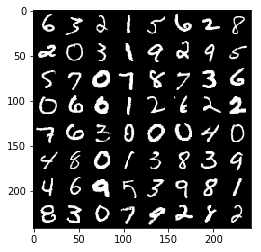

In [10]:
def imshow(img):
    img = img # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'%int(labels.numpy()[j]) for j in range(trainloader.batch_size)))

In [11]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

net = Net()
net.cuda()
net

Net (
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d (p=0.5)
  (fc1): Linear (320 -> 50)
  (fc2): Linear (50 -> 10)
)

In [12]:
params = list(net.parameters())
print(len(params))
print(params[0].size())
print(params[2].size())
print(params[4].size())

8
torch.Size([10, 1, 5, 5])
torch.Size([20, 10, 5, 5])
torch.Size([50, 320])


In [13]:
optimizer = optim.Adam(net.parameters(),lr=0.0001)

In [14]:
def train(epoch):
    net.train()
    for batch_index, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = Variable(inputs), Variable(torch.squeeze(labels))
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        if batch_index % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_index * len(inputs), len(trainloader.dataset),
                    100. * batch_index / len(trainloader), loss.data[0]))

In [15]:
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(torch.squeeze(target))
        output = net(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))

In [ ]:
for epoch in range(16): # loop over the dataset multiple times
    train(epoch)
    test(epoch)

Train Epoch: 0 [0/33600 (0%)]	Loss: 2.312326
Train Epoch: 0 [6400/33600 (19%)]	Loss: 2.280845
Train Epoch: 0 [12800/33600 (38%)]	Loss: 2.075958
Train Epoch: 0 [19200/33600 (57%)]	Loss: 1.709425
Train Epoch: 0 [25600/33600 (76%)]	Loss: 1.359656
Train Epoch: 0 [32000/33600 (95%)]	Loss: 0.954555

Test set: Average loss: 0.8570, Accuracy: 14949/18870 (79%)

Train Epoch: 1 [0/33600 (0%)]	Loss: 1.244148
Train Epoch: 1 [6400/33600 (19%)]	Loss: 0.749903
Train Epoch: 1 [12800/33600 (38%)]	Loss: 0.823581
Train Epoch: 1 [19200/33600 (57%)]	Loss: 0.830648
Train Epoch: 1 [25600/33600 (76%)]	Loss: 0.552553
Train Epoch: 1 [32000/33600 (95%)]	Loss: 0.704887

Test set: Average loss: 0.4501, Accuracy: 16687/18870 (88%)

Train Epoch: 2 [0/33600 (0%)]	Loss: 0.716729
Train Epoch: 2 [6400/33600 (19%)]	Loss: 0.549301
Train Epoch: 2 [12800/33600 (38%)]	Loss: 0.758139
Train Epoch: 2 [19200/33600 (57%)]	Loss: 0.540438
Train Epoch: 2 [25600/33600 (76%)]	Loss: 0.519530
Train Epoch: 2 [32000/33600 (95%)]	Loss: 0.7

In [ ]:
test_df = pd.read_csv("input/test.csv")
test_cube = cube_data(test_df)
ntest = test_cube.shape[0]
test_cube = torch.FloatTensor(test_cube)

In [ ]:
test_cube = test_cube.cuda()

In [ ]:
pred = net(Variable(test_cube))

In [ ]:
_, predicted = torch.max(pred, 1)

In [ ]:
predicted

In [ ]:
d = {'ImageId' : pd.Series(np.arange(1, ntest + 1)), 
     'Label' : pd.Series(predicted.data.squeeze().cpu().numpy())}
test_df = pd.DataFrame(d)
test_df.to_csv("output/submit.csv", index = False)